In [130]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import time

In [3]:
df = pd.read_csv('intermediate-data/nfl_team_all_stats_2013_2022.csv', index_col=['Year', 'Team'])
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 320 entries, (2022, 'Seattle Seahawks') to (2021, 'Seattle Seahawks')
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MadePlayoffs                     320 non-null    float64
 1   QB_COST                          320 non-null    int64  
 2   RB_COST                          320 non-null    int64  
 3   WR_COST                          320 non-null    int64  
 4   TE_COST                          320 non-null    int64  
 5   OL_COST                          320 non-null    int64  
 6   Offense_COST                     320 non-null    int64  
 7   IDL_COST                         320 non-null    int64  
 8   EDGE_COST                        320 non-null    int64  
 9   LB_COST                          320 non-null    int64  
 10  S_COST                           320 non-null    int64  
 11  CB_COST                          320

In [4]:
df.head()

MadePlayoffs   QB_COST   RB_COST   WR_COST  \
Year Team                                                              
2022 Seattle Seahawks              1.0   1557085  10799653  16831423   
     San Francisco 49ers           1.0   2897535   9284062  16963177   
     Arizona Cardinals             0.0   6172993   5306754  15022466   
     Los Angeles Rams              0.0  13705176   2637944   5479738   
     Carolina Panthers             0.0   7579454   9290450  11041036   

                           TE_COST   OL_COST  Offense_COST  IDL_COST  \
Year Team                                                              
2022 Seattle Seahawks     12778788  27955261      69922210   7701509   
     San Francisco 49ers  10569598  17581156      57295528  11028483   
     Arizona Cardinals     4425078  19171690      50098981  20498000   
     Los Angeles Rams      6217555  19240160      47280573   9376091   
     Carolina Panthers     4325000  18981126      51217066   5096152   

                          EDGE_COST   LB_COST  ...  defense_ave_wpa_pass  \
Year Team                                      ...                         
2022 Seattle Seahawks      25013832   7377232  ...              0.002187   
     San Francisco 49ers   10194288   7666512  ...             -0.001752   
     Arizona Cardinals      5347625   7964030  ...              0.001529   
     Los Angeles Rams      13967275  15711252  ...              0.003280   
     Carolina Panthers     11629844  12335911  ...              0.001560   

                          defense_ave_wpa_run  defense_success_rate_pass  \
Year Team                                                                  
2022 Seattle Seahawks                0.002329                   0.424958   
     San Francisco 49ers            -0.002444                   0.422535   
     Arizona Cardinals               0.002561                   0.508716   
     Los Angeles Rams                0.002446                   0.477234   
     Carolina Panthers              -0.000132                   0.455285   

                          defense_success_rate_run  points_scored  \
Year Team                                                           
2022 Seattle Seahawks                     0.410609            407   
     San Francisco 49ers                  0.370370            450   
     Arizona Cardinals                    0.435897            340   
     Los Angeles Rams                     0.415730            307   
     Carolina Panthers                    0.425263            347   

                          points_allowed  wins  losses  ties  \
Year Team                                                      
2022 Seattle Seahawks                401     9       8     0   
     San Francisco 49ers             277    13       4     0   
     Arizona Cardinals               449     4      13     0   
     Los Angeles Rams                384     5      12     0   
     Carolina Panthers               374     7      10     0   

                          score_differential  
Year Team                                     
2022 Seattle Seahawks                      6  
     San Francisco 49ers                 173  
     Arizona Cardinals                  -109  
     Los Angeles Rams                    -77  
     Carolina Panthers                   -27  

[5 rows x 67 columns]

In [5]:
# dataset balance of subscribed class (derived from column '1 or 0').
df['MadePlayoffs'].value_counts()

MadePlayoffs
0.0    194
1.0    126
Name: count, dtype: int64

In [6]:
# get column names for target categories, off-stats, def-stats, off-cost, def-cost
target_categorical_columns = ['points_scored', 'points_allowed', 'score_differential', 'MadePlayoffs', 'wins', 'losses', 'ties']
off_cost_columns =  ['QB_COST', 'RB_COST', 'WR_COST', 'TE_COST', 'OL_COST', 'Offense_COST']
def_cost_columns = ['IDL_COST', 'EDGE_COST', 'LB_COST', 'S_COST', 'CB_COST', 'Defense_COST']
off_stats_columns = ['offense_completion_percentage', 'offense_total_yards_gained_pass', 'offense_total_yards_gained_run', 'offense_ave_yards_gained_pass', 'offense_ave_yards_gained_run', 'offense_total_air_yards', 'offense_ave_air_yards', 'offense_total_yac', 'offense_ave_yac', 'offense_n_plays_pass', 'offense_n_plays_run', 'offense_n_interceptions', 'offense_n_fumbles_lost_pass', 'offense_n_fumbles_lost_run', 'offense_total_epa_pass', 'offense_total_epa_run', 'offense_ave_epa_pass', 'offense_ave_epa_run', 'offense_total_wpa_pass', 'offense_total_wpa_run', 'offense_ave_wpa_pass', 'offense_ave_wpa_run', 'offense_success_rate_pass', 'offense_success_rate_run']
def_stats_columns = ['defense_completion_percentage', 'defense_total_yards_gained_pass', 'defense_total_yards_gained_run', 'defense_ave_yards_gained_pass', 'defense_ave_yards_gained_run', 'defense_total_air_yards', 'defense_ave_air_yards', 'defense_total_yac', 'defense_ave_yac', 'defense_n_plays_pass', 'defense_n_plays_run', 'defense_n_interceptions', 'defense_n_fumbles_lost_pass', 'defense_n_fumbles_lost_run', 'defense_total_epa_pass', 'defense_total_epa_run', 'defense_ave_epa_pass', 'defense_ave_epa_run', 'defense_total_wpa_pass', 'defense_total_wpa_run', 'defense_ave_wpa_pass', 'defense_ave_wpa_run', 'defense_success_rate_pass', 'defense_success_rate_run']

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_columns = df.drop(['points_scored', 'points_allowed', 'score_differential', 'MadePlayoffs', 'wins', 'losses', 'ties'], axis=1).columns.tolist()

# create training and test data frames where the training data is from the year prior to 2021 and
# test data is after 2020.

# target categories
y_lte_2020 = df.loc[:, ['MadePlayoffs']].query('Year <= 2020').MadePlayoffs.reset_index(drop=True) # training data
y_gt_2020 = df.loc[:, ['MadePlayoffs']].query('Year > 2020').MadePlayoffs.reset_index(drop=True) #test data

# feature data
target_list = off_stats_columns + def_stats_columns + list(['points_scored', 'points_allowed', 'score_differential', 'wins', 'losses', 'ties'])
X_lte_2020 = df.loc[:, target_list].query('Year <= 2020').reset_index(drop=True) # training data
X_gt_2020 = df.loc[:, target_list].query('Year > 2020').reset_index(drop=True) # test data


In [7]:
X_lte_2020.head()


,offense_completion_percentage,offense_total_yards_gained_pass,offense_total_yards_gained_run,offense_ave_yards_gained_pass,offense_ave_yards_gained_run,offense_total_air_yards,offense_ave_air_yards,offense_total_yac,offense_ave_yac,offense_n_plays_pass,...,defense_ave_wpa_pass,defense_ave_wpa_run,defense_success_rate_pass,defense_success_rate_run,points_scored,points_allowed,score_differential,wins,losses,ties
0,0.570571,4091,2084,6.142643,4.590308,5288,8.474359,2014,5.300000,666,...,-0.000379,-0.000629,0.430818,0.416842,444,338,106,12,4,0
1,0.505703,2932,2164,5.574144,4.461856,4326,9.031315,1345,5.056391,526,...,0.000320,-0.003379,0.433600,0.297561,290,387,-97,8,8,0
2,0.550077,3567,1447,5.496148,4.255882,5690,9.660441,1535,4.299720,649,...,-0.002415,0.001803,0.434572,0.445161,317,335,-18,8,8,0
3,0.523643,3107,2338,5.441331,4.428030,4506,8.648752,1508,5.043478,571,...,-0.003505,-0.000593,0.378029,0.368421,339,388,-49,6,10,0
4,0.590909,4136,1770,6.714286,3.839479,5023,8.571672,2080,5.714286,616,...,-0.002240,-0.003505,0.422018,0.342105,430,305,125,11,5,0


In [8]:
def encodeCategory(y) :
    """
    Encode the target category/class using a
    label encoder

    Args: 
        y: target category from data set
    
    Returns:
        y_encoded: encoded version of target category from data set
    """
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return y_encoded


In [9]:
#encode training data
y_lte_2020_encoded = encodeCategory(y_lte_2020)

#encode test data
y_gt_2020_encoded =  encodeCategory(y_gt_2020)

In [10]:
def rmse(y_test, y_pred) :
    """
    get root mean squared error using test data and predicted results

    Args:
        y_test: target category from test data
        y_pred: predicted target catagory from test data

    Returns:
        float: root mean squared error (RMSE)
    """
    return np.sqrt(mean_squared_error(y_test, y_pred))

# create root mean squared error function as scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False, response_method=['predict'])

def createEncoderPreprocessor(scaler, feature_columns) :
    """
    use standard scaler to scale all features to unit variance

    Args:
        scaler: method used to scale data set (i.e. StandardScaler(), OrdinalEncoder)
        feature_columns: list of feature names
    
    Returns:
        transformer object containing the StandardScaler as the preprocessor
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ('encoder', scaler, feature_columns)
        ])
    return preprocessor

# default encoder/scaler
ENCODER = StandardScaler()




In [ ]:
# Baseline models
models = {
    'knn-c': (KNeighborsClassifier()),
    'decisiontree-c': (DecisionTreeClassifier(random_state=42)),
    'randomforest-c': (RandomForestClassifier(random_state=42)),
    'svc': (SVC(random_state=42))
}

In [12]:
def executeModelsForBaselineEval(pipe_models, X_train, y_train, X_test, y_test, scorer_fx) :
    """
    Execute pipeline containing encoded data
    and target models with a custom scorer function

    Args: 
        pipe_model: list of models
        X_train: DataFrame: contains training features
        y_train: ndarray: contains target category training data
        X_test: DataFrame: contains test features
        y_test: ndarray: contains target category test data
        scorer_fx: error function
    
    Returns:
        DataFrame: contains results for each model.
    """
    results = []
    for name, (model) in pipe_models.items():
        # Create a pipeline
        pipeline = Pipeline([
            ('preprocessor', createEncoderPreprocessor(ENCODER, X_train.columns.tolist())),
            (name, model)
        ])
        feature_cnt = len(X_train.columns.tolist())
        
        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid={}, cv=5, n_jobs=-1, scoring=scorer_fx)
        
        # Fit the model and time it
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
        
        # Get the best estimator
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        ## print("Best params: \n", grid_search.best_params_)
        # print("\nBest estimator: \n", grid_search.best_estimator_)
        
        # Evaluate on training and test sets
        train_score = best_model.score(X_train, y_train)
        test_score = best_model.score(X_test, y_test)

        # extract best root mean squared error
        best_rmse = -grid_search.best_score_
        # print(f"best RMSE: {best_rmse}")
        
        # Append the results
        results.append([name + '-baseline', feature_cnt, best_params, train_score, test_score, best_rmse, fit_time])

    # Create the results DataFrame
    results_df = pd.DataFrame(results, columns=['model', 'feature count', 'best params', 'train score', 'test score', 'rmse', 'average fit time'])
    results_df.reset_index(inplace=True)

    return results_df


In [13]:
# STEP 1: Feature Selection - get baseline using X training features allstats_X_train

# create baseline models for all-stats vs score differential
results_df = executeModelsForBaselineEval(models, X_lte_2020, y_lte_2020_encoded, X_gt_2020, y_gt_2020_encoded, rmse_scorer)

results_df.to_json('results/allstats_makeplayoffs_baseline_model_results_df.json', orient='records', double_precision=10)

# baseline results
baseline_df = pd.read_json(r'results/allstats_makeplayoffs_baseline_model_results_df.json')
baseline_df[['model', 'train score','test score', 'rmse','average fit time']]


,model,train score,test score,rmse,average fit time
0,knn-c-baseline,0.910156,0.828125,0.354344,1.913667
1,decisiontree-c-baseline,1.000000,0.906250,0.335189,1.180622
2,randomforest-c-baseline,1.000000,0.875000,0.277802,1.517954
3,svc-baseline,0.957031,0.828125,0.351932,0.993472


In [ ]:
def createCorrelationHeatMap(X, figsize) :
    """
    Calculate the correlation between features
    and create a heat map from the results

    Args:
        X: DataFrame: contains feature data
        figsize: tuple containing the size of the diagram
    """
    corr = X.corr()

    # Generate the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr,annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black',
                xticklabels=corr.columns, yticklabels=corr.columns)  # Consider turning off annotations for speed
    plt.show()

def calculatePermutationImportance(model, X_train, y_train, X_test, y_test, encoder=None) :
    """
    this calculates each feature's permutation-importance on the test data
    using a model regressor (i.e. RandomForestRegressor(n_estimators=100, random_state=42))
     
    NOTE: can be used to compare accuracy and correlation of features with permutation importance
    If high accuracy is observed with no features having importance there might be multicollinearity
    occuring within feature set.
     
    Return: Tuple {
                   data frame: containing importance score for each column in training/test data, 
                   float:      accuracy score from baseline prediction using model-regressor
                  }

    Args:
        model: model used for selecting features
        X_train: features from training data set
        y_train: category from training data set
        X_test: features from test data set
        y_test: category from test data set
        encoder: type of scaler/encoder to encoding the data set
    
    Returns:
        dict: list of features with importance value
        float: number of features
        float: score
        error: RMSE

    """
    # set encoder
    if (encoder == None):
        encoder = ENCODER # default

    pipe_model = Pipeline([('preprocessor', createEncoderPreprocessor(encoder, X_train.columns.tolist())),
                           ('regressor', model)
                        ])
    
    pipe_model.fit(X_train, y_train)
    score = pipe_model.score(X_test, y_test)
    y_pred = pipe_model.predict(X_test)
    error = rmse(y_test, y_pred)

    results = permutation_importance(pipe_model, X_test, y_test, n_repeats=10, n_jobs=-1, random_state=42)
    results_df = pd.DataFrame(data=results.importances_mean, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

    return results_df, len(results_df), score, error



In [16]:
# all stats vs making playoffs
step1_perm_imp_selected_features_rfc, feature_cnt, score, error = calculatePermutationImportance(RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1),
                                            X_lte_2020, y_lte_2020_encoded, X_gt_2020, y_gt_2020_encoded
                                        )
print(f'STEP 1: Feature Evaluation using RandomForestClassifier for [total stats vs Making to playoffs]:\nAccuracy: total feature-count: {feature_cnt}, accuracy: {score}, RMSE: {error}\n{step1_perm_imp_selected_features_rfc.query('Importance > 0')}\n')

step1_perm_imp_selected_features_dtc, feature_cnt, score, error = calculatePermutationImportance(DecisionTreeClassifier(random_state=42),
                                            X_lte_2020, y_lte_2020_encoded, X_gt_2020, y_gt_2020_encoded
                                        )
print(f'STEP 1: Feature Evaluation using DecisionTreeClassifier for [total stats vs Making to playoffs]:\nAccuracy: total feature-count: {feature_cnt}, accuracy: {score}, RMSE: {error}\n{step1_perm_imp_selected_features_dtc.query('Importance > 0')}\n')


c:\Users\steve\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


STEP 1: Feature Evaluation using RandomForestClassifier for [total stats vs Making to playoffs]:
Accuracy: total feature-count: 54, accuracy: 0.875, RMSE: 0.3535533905932738
                                Importance
wins                              0.053125
losses                            0.028125
defense_total_yards_gained_run    0.015625
points_allowed                    0.014063
defense_ave_wpa_run               0.012500
defense_n_plays_run               0.012500
defense_total_wpa_run             0.010937
score_differential                0.010937
offense_total_wpa_run             0.010937
defense_ave_wpa_pass              0.009375
offense_ave_wpa_run               0.009375
defense_total_wpa_pass            0.007812
offense_total_epa_run             0.004687
offense_ave_epa_run               0.004687
offense_n_interceptions           0.003125
offense_ave_yac                   0.003125
offense_total_yards_gained_run    0.003125
defense_n_interceptions           0.003125
defense_a

In [27]:
# create feature lists from results using permutation importance
step1_perm_imp_selected_features = {}
step1_perm_imp_selected_features['rf-c'] = step1_perm_imp_selected_features_rfc.query('Importance > 0').index.values
step1_perm_imp_selected_features['dt-c'] = step1_perm_imp_selected_features_dtc.query('Importance > 0').index.values
step1_perm_imp_selected_features['default'] = None

step1_perm_imp_selected_features

{'rf-c': array(['wins', 'losses', 'defense_total_yards_gained_run',
        'points_allowed', 'defense_ave_wpa_run', 'defense_n_plays_run',
        'defense_total_wpa_run', 'score_differential',
        'offense_total_wpa_run', 'defense_ave_wpa_pass',
        'offense_ave_wpa_run', 'defense_total_wpa_pass',
        'offense_total_epa_run', 'offense_ave_epa_run',
        'offense_n_interceptions', 'offense_ave_yac',
        'offense_total_yards_gained_run', 'defense_n_interceptions',
        'defense_ave_yards_gained_pass', 'defense_success_rate_pass',
        'offense_ave_yards_gained_run'], dtype=object),
 'dt-c': array(['wins', 'losses', 'defense_ave_epa_run',
        'offense_success_rate_run', 'defense_ave_yards_gained_pass'],
       dtype=object),
 'default': None}

In [ ]:

# Calculate the correlation matrix for the entire data set
createCorrelationHeatMap(X=X_lte_2020, figsize=(40, 32))


In [84]:

def calculateOptimalPath(X_train, y_train, X_test, y_test) :
    """
    Calculate optimal paths using DecisionTree.cost_complexity_pruning(...) while
    using the full feature set.
    
    Args:
        X_train: training data
        y_train: target feature/class from training data
        X_test: test data
        y_test: target feature/class from test data
    
    Returns:
        (Dataframe, Pruning Path):
            Dataframe: ['best params', 'ccp-alpha', 'node count', 'depth', 'train accuracy', 'test accuracy', 'rmse']
            Pruning Path: pruning path and results from fitted DecisionTreeClassifier model
        
    """
    # init
    results = []

    dtree = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)
    path = dtree.cost_complexity_pruning_path(X_train, y_train)
    # print('CCP Alphas and Impurities:\n', path)

    ccp_alphas = path.ccp_alphas
    impurities = path.impurities

    preprocessor = createEncoderPreprocessor(ENCODER, X_train.columns.tolist())

    # calculate node counts, different depths and accuracy based on the provided ccp alpha values
    idx = 0
    for i in ccp_alphas[:-1]:
        # Create a pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ("dt-c", DecisionTreeClassifier(random_state=42, ccp_alpha=i))
        ])

        model_grid = GridSearchCV(pipeline, param_grid={}, cv=10, n_jobs=-1, scoring=rmse_scorer) # using default criterion - gini
        model_grid.fit(X_train, y_train)
        best_model = model_grid.best_estimator_
        best_params = model_grid.best_params_

        # Append the results
        results.append([best_params
                        , i # ccp-alpha
                        , impurities[idx]
                        , best_model.named_steps['dt-c'].tree_.node_count
                        , best_model.named_steps['dt-c'].get_depth()
                        , best_model.score(X_train, y_train)
                        , best_model.score(X_test, y_test)
                        , -model_grid.best_score_])
        idx += 1

    # Create the results DataFrame
    results_df = pd.DataFrame(results, columns=['best params', 'ccp-alpha', 'impurities', 'node count', 'depth', 'train accuracy', 'test accuracy', 'rmse'])
    results_df.reset_index(inplace=True)

    # return results and pruning path containing ccp-alphas and impurities
    return results_df, path

def showImpureNodesVsCcpAlphas(path) :
    """
    Graphically show the relation between impure nodes and the ccp alpha values
    Args:
        path: DecisionTreeClassifier pruning path
    """

    plt.step(path.ccp_alphas[:-1], path.impurities[:-1], '--o')
    plt.title('Impurity vs. Effective Alpha')
    plt.xlabel('Effective Alphas')
    plt.ylabel('Total Impurity of Leaves')

def showCcpAlphasVsOptimalNodes(nodes, ccp_alphas) :
    """
    Graphically show CCP Alphas in relation to the number of optimal nodes
    Args:
        nodes: list of optimal nodes
        ccp_alphas: list of alphas
    """
    plt.step(ccp_alphas[:-1], nodes, '--o')
    plt.xlabel('Alpha')
    plt.ylabel('Nodes')
    plt.title('CCP Alpha vs. Number of Nodes')
    plt.grid()

def showCcpAlphasVsAccuracy(pruning_path_results_df) :
    """
    show the RMSE for each ccp alpha including the best accuracy score
    """
    train_accs = pruning_path_results_df['train accuracy'].to_numpy()
    test_accs = pruning_path_results_df['test accuracy'].to_numpy()
    ccp_alphas = pruning_path_results_df['ccp-alpha'].to_numpy()
    depths = pruning_path_results_df['depth'].to_numpy()
    nodes = pruning_path_results_df['node count'].to_numpy()
    rmses = pruning_path_results_df['rmse'].to_numpy()

    plt.step(ccp_alphas, train_accs, '--o', label = 'Train')
    plt.step(ccp_alphas, test_accs, '--o', label = 'Test')
    plt.plot(ccp_alphas[np.argmax(test_accs)], max(test_accs), 'ro', markersize = 12, alpha = 0.4, label = 'Best Accuracy')
    plt.legend()
    plt.grid()
    plt.title('Accuracy vs Alpha')
    plt.xlabel('alpha')
    plt.ylabel('Accuracy')

    ccp_alpha_best_idx = np.argmax(test_accs)
    print(f"Best score using all features: {max(test_accs)} <-> CCP Alpha: {ccp_alphas[ccp_alpha_best_idx]} - depth: {depths[ccp_alpha_best_idx]} - nodes: {nodes[ccp_alpha_best_idx]}, rmse: {rmses[ccp_alpha_best_idx]}")

def showBestRmseWithAccuracy(pruning_path_results_df) :
    """
    show the RMSE for each ccp alpha including the best accuracy score
    """
    # train_accs = pruning_path_results_df['train accuracy'].to_numpy()
    test_accs = pruning_path_results_df['test accuracy'].to_numpy()
    ccp_alphas = pruning_path_results_df['ccp-alpha'].to_numpy()
    depths = pruning_path_results_df['depth'].to_numpy()
    nodes = pruning_path_results_df['node count'].to_numpy()
    rmses = pruning_path_results_df['rmse'].to_numpy()

    # plt.step(rmses, train_accs, '--o', label = 'Train')
    plt.step(test_accs, rmses, '--o', label = 'Error')
    plt.plot(test_accs[np.argmin(rmses)], min(rmses), 'ro', markersize = 12, alpha = 0.4, label = 'Best Error')
    plt.legend()
    plt.grid()
    plt.title('Error vs Accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('Error (RMSE)')

    rmse_best_idx = np.argmin(rmses)
    print(f"Best score using all features: {min(rmses)} <-> CCP Alpha: {ccp_alphas[rmse_best_idx]} - depth: {depths[rmse_best_idx]} - nodes: {nodes[rmse_best_idx]}, test accuracy: {test_accs[rmse_best_idx]}")

def showCcpAlphasVsRootMeanSquaredError(pruning_path_results_df) :
    """
    show the root mean squared error for each ccp alpha including the best / minimum error
    """
    train_accs = pruning_path_results_df['train accuracy'].to_numpy()
    test_accs = pruning_path_results_df['test accuracy'].to_numpy()
    ccp_alphas = pruning_path_results_df['ccp-alpha'].to_numpy()
    depths = pruning_path_results_df['depth'].to_numpy()
    nodes = pruning_path_results_df['node count'].to_numpy()
    rmses = pruning_path_results_df['rmse'].to_numpy()
    ccp_alpha_best_idx = np.argmin(rmses)
    
    plt.step(pruning_path_results_df['ccp-alpha'].to_numpy(), pruning_path_results_df['rmse'].to_numpy(), '--o')
    plt.xlabel('Alpha')
    plt.ylabel('Error (RMSE)')
    plt.title('CCP Alpha vs. Root Mean Squared Error (RMSE)')
    plt.grid()

    print(f"Best score using all features: Train accuracy: {train_accs[ccp_alpha_best_idx]}, Test accuracy: {test_accs[ccp_alpha_best_idx]} <-> CCP Alpha: {ccp_alphas[ccp_alpha_best_idx]} - depth: {depths[ccp_alpha_best_idx]} - nodes: {nodes[ccp_alpha_best_idx]}, rmse: {rmses[ccp_alpha_best_idx]}")



In [85]:
step2_pruning_path_results_df, pruning_paths = calculateOptimalPath(X_lte_2020, y_lte_2020_encoded, X_gt_2020, y_gt_2020_encoded)
step2_pruning_path_results_df

,index,best params,ccp-alpha,impurities,node count,depth,train accuracy,test accuracy,rmse
0,0,{},0.000000,0.000000,33,6,1.000000,0.906250,0.305224
1,1,{},0.003815,0.015262,25,6,0.992188,0.906250,0.305224
2,2,{},0.005133,0.030662,19,5,0.984375,0.921875,0.298867
3,3,{},0.005859,0.036521,17,4,0.980469,0.921875,0.268046
4,4,{},0.007284,0.051089,13,4,0.972656,0.921875,0.274279
5,5,{},0.007535,0.058624,11,4,0.968750,0.921875,0.274279
6,6,{},0.011719,0.070343,9,4,0.960938,0.921875,0.241812
7,7,{},0.013672,0.084015,7,3,0.953125,0.890625,0.233689
8,8,{},0.020926,0.104941,5,2,0.929688,0.890625,0.252965
9,9,{},0.025149,0.130090,3,1,0.929688,0.890625,0.269373


In [ ]:

# graphically show the relation between impure nodes and the ccp alpha values
showImpureNodesVsCcpAlphas(pruning_paths)


In [ ]:
# graphically show the ccp alpha in relation to the number of optimal nodes
showCcpAlphasVsOptimalNodes(step2_pruning_path_results_df['node count'].values, pruning_paths.ccp_alphas)


In [ ]:
# show the accuracy for each ccp alpha including the best accuracy score
showCcpAlphasVsAccuracy(step2_pruning_path_results_df)


In [ ]:
# show comparison between CCP-Alpha and root mean squared error (RMSE)
showCcpAlphasVsRootMeanSquaredError(step2_pruning_path_results_df)

In [ ]:
# show best root mean squared errors with accuracy
showBestRmseWithAccuracy(step2_pruning_path_results_df)

In [142]:


def evaluateModel(model_name, model, hyperparams, ccp_alphas, X_train, y_train, X_test, y_test, pi_model_name=None, feature_list=None) :
    """
    Creates a dictionary containing the results from the model that was tested using GridSearchCV

    Args:
        model_name: name of model for GridSearchCV
        model: model being evaluated
        hyperparams: hyper-parameters used during GridSearch
        ccp_alphas: list of ccp-alpha values
        X_train : X features from training data set
        y_train : target category from training data set

    Returns:
        DataFrame: containing results from GridSearchCV
            Attributes: 'model', 'best params', 'train score', 'test score', 'rmse', 'fit time (seconds)'
    """
    results = []

    # set feature list to default
    if pi_model_name is None:
        pi_model_name = 'default'
    if feature_list is None :
        feature_list = X_train.columns.tolist()
    # print(f"features: {feature_list}")

    # add ccp-alphas to hyperparameters for grid search
    if (ccp_alphas is not None) :
        hyperparams[model_name + '__ccp_alpha'] = ccp_alphas

    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', createEncoderPreprocessor(ENCODER, feature_list)),
        (model_name, model)
    ])

    model_grid = GridSearchCV(pipeline, param_grid=hyperparams, cv=10, n_jobs=-1, scoring=rmse_scorer)

    # fit model    
    start_time = time.time()
    model_grid.fit(X_train[feature_list], y_train)
    fit_time = (time.time() - start_time) / len(model_grid.cv_results_['mean_fit_time']) 

    # Get the best estimator
    best_model = model_grid.best_estimator_
    best_params = model_grid.best_params_
    # print("Best params: \n", model_grid.best_params_)
    # print("\nBest estimator: \n", model_grid.best_estimator_)
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train[feature_list], y_train)
    test_score = best_model.score(X_test[feature_list], y_test)
    test_cm = confusion_matrix(y_test, best_model.predict(X_test))

    # extract best root mean squared error (RMSE)
    best_rmse = -model_grid.best_score_
    # print(f"best RMSE: {best_rmse}")
    
    # Append the results
    results.append([model_name, best_params, pi_model_name, len(feature_list), train_score, test_score, best_rmse, test_cm, fit_time])

    # Create the results DataFrame
    results_df = pd.DataFrame(results, columns=['model', 'best params', "perm-imp model", "feature count", 'train score', 'test score', 'rmse', 'test cm', 'fit time (seconds)'])
    results_df.reset_index(inplace=True)

    return results_df





In [149]:
# models being evaluated
tree_models = {
    'dt-c': (DecisionTreeClassifier(random_state=42), {
                                                    # 'dt-c__criterion': ['gini', 'entropy', 'log_loss'],
                                                    # 'dt-c__splitter' : ['best', 'random']
                                                }),
    'rf-c': (RandomForestClassifier(random_state=42, n_jobs=-1), {
                                                    'rf-c__n_estimators': [100, 1000],
                                                    # 'rf-c__criterion': ['gini', 'entropy', 'log_loss']
                                                }),
}



In [150]:
''
# STEP 3: Evaluate target models RandomForestClassifier and DecisionTreeClassifier
print("STEP 3: Evaluate target models using results from node pruning task (step 2)")
all_model_eval_results_df = pd.DataFrame()
for pi_model_name, feature_list in step1_perm_imp_selected_features.items() :
    print(f"PI model: {pi_model_name}, features: {feature_list}")
    for model_name, (model, hyperparams) in tree_models.items() :
        print(f"model: {model_name}, hyper-params: {hyperparams}")
        model_eval_results_df = evaluateModel(model_name, model, hyperparams
                                            , step2_pruning_path_results_df.query("`ccp-alpha` >= 0.005133 and `ccp-alpha` <= 0.013672")['ccp-alpha'].to_numpy()
                                            , X_lte_2020, y_lte_2020_encoded, X_gt_2020, y_gt_2020_encoded
                                            , pi_model_name, feature_list)
        all_model_eval_results_df = pd.concat([all_model_eval_results_df, model_eval_results_df])

all_model_eval_results_df

STEP 3: Evaluate target models using results from node pruning task (step 2)
PI model: rf-c, features: ['wins' 'losses' 'defense_total_yards_gained_run' 'points_allowed'
 'defense_ave_wpa_run' 'defense_n_plays_run' 'defense_total_wpa_run'
 'score_differential' 'offense_total_wpa_run' 'defense_ave_wpa_pass'
 'offense_ave_wpa_run' 'defense_total_wpa_pass' 'offense_total_epa_run'
 'offense_ave_epa_run' 'offense_n_interceptions' 'offense_ave_yac'
 'offense_total_yards_gained_run' 'defense_n_interceptions'
 'defense_ave_yards_gained_pass' 'defense_success_rate_pass'
 'offense_ave_yards_gained_run']
model: dt-c, hyper-params: {}
model: rf-c, hyper-params: {'rf-c__n_estimators': [100, 1000]}
PI model: dt-c, features: ['wins' 'losses' 'defense_ave_epa_run' 'offense_success_rate_run'
 'defense_ave_yards_gained_pass']
model: dt-c, hyper-params: {'dt-c__ccp_alpha': array([0.00513339, 0.00585938, 0.00728396, 0.00753509, 0.01171875,
       0.01367188])}
model: rf-c, hyper-params: {'rf-c__n_estimato

,index,model,best params,perm-imp model,feature count,train score,test score,rmse,test cm,fit time (seconds)
0,0,dt-c,{'dt-c__ccp_alpha': 0.013671875},rf-c,21,0.953125,0.890625,0.233689,"[[36, 0], [7, 21]]",0.479384
0,0,rf-c,"{'rf-c__ccp_alpha': 0.005859375, 'rf-c__n_esti...",rf-c,21,0.988281,0.875000,0.257147,"[[36, 0], [8, 20]]",0.924184
0,0,dt-c,{'dt-c__ccp_alpha': 0.007283958773784356},dt-c,5,0.964844,0.921875,0.261196,"[[36, 0], [5, 23]]",0.016670
0,0,rf-c,"{'rf-c__ccp_alpha': 0.005133393285371706, 'rf-...",dt-c,5,0.972656,0.890625,0.251075,"[[36, 0], [7, 21]]",0.948735
0,0,dt-c,{'dt-c__ccp_alpha': 0.013671875},default,54,0.953125,0.890625,0.233689,"[[36, 0], [7, 21]]",0.023309
0,0,rf-c,"{'rf-c__ccp_alpha': 0.005133393285371706, 'rf-...",default,54,0.996094,0.875000,0.270687,"[[36, 0], [8, 20]]",1.047219


In [135]:
def showConfusionMatrixForMakingPlayoffs(cm) :
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    classes = ['made playoffs', 'missed playoffs']
    disp.plot()
    plt.title('Made Playoffs vs Missed')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(np.arange(len(classes)), classes)
    plt.yticks(np.arange(len(classes)), classes)
    plt.show()

    

Model Cfg: index                                                         0
model                                                      dt-c
best params           {'dt-c__ccp_alpha': 0.007283958773784356}
perm-imp model                                             dt-c
feature count                                                 5
train score                                            0.964844
test score                                             0.921875
rmse                                                   0.261196
test cm                                      [[36, 0], [5, 23]]
fit time (seconds)                                     0.016818
Name: 0, dtype: object


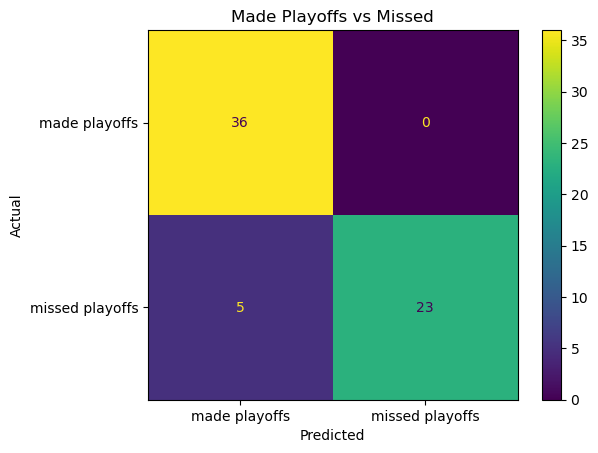

In [140]:
# show confustion matrix for best model
print(f"Model Cfg: {all_model_eval_results_df.iloc[2]}")
showConfusionMatrixForMakingPlayoffs(all_model_eval_results_df['test cm'].iloc[2])

In [ ]:
# compare previous with the best baseline: hyper-params:{}, ccp-alpha: 0.011719, impurities: 0.070343, nodes: 9, depth: 4, training score: 0.960938, test score: 0.921875, rmse: 0.241812
# this ended up with the best results due to a slightly lower RMSE with giving up any accuracy
model_eval_results_df = evaluateModel('dt-c-best-baseline', DecisionTreeClassifier(random_state=42), {}
                                    , [0.011719]
                                    , X_lte_2020, y_lte_2020_encoded, X_gt_2020, y_gt_2020_encoded
                                    , None, None)
model_eval_results_df


,index,model,best params,perm-imp model,feature count,train score,test score,rmse,test cm,fit time (seconds)
0,0,dt-c-best-baseline,{'dt-c-best-baseline__ccp_alpha': 0.011719},default,54,0.960938,0.921875,0.241812,"[[36, 0], [5, 23]]",2.225046


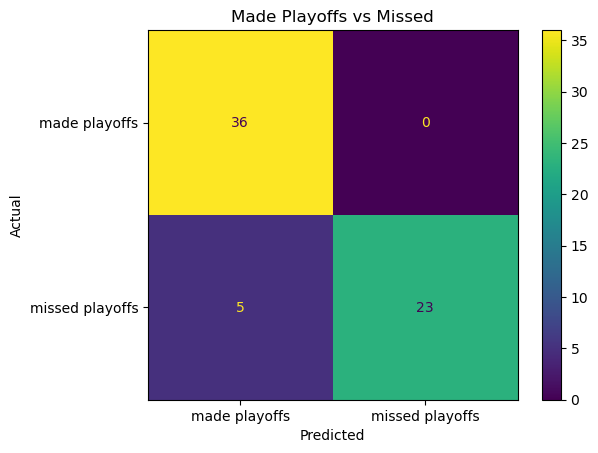

In [139]:
showConfusionMatrixForMakingPlayoffs(model_eval_results_df['test cm'].iloc[0])

In [ ]:
non_tree_models = {
    'knn-c': (KNeighborsClassifier(n_jobs=-1), {
                                    'knn-c__n_neighbors': list(range(1, 22, 2)),
                                    'knn-c__weights': ['uniform', 'distance'],
                                    'knn-c__p': [1, 2],
                                }),
    'svc': (SVC(random_state=42), {
                                    'svc__C': [0.1, 1, 10],
                                    'svc__kernel': ['linear', 'rbf', 'poly', 'linear', 'sigmoid'],
                                    'svc__gamma': [0.1, 1.0, 10],
                                })

}

# STEP 3 (continued): Evaluate target models SVC snd K-Nearest-Neighbor Classifier
print("STEP 3: Evaluate target models using results from node pruning task (step 2)")
all_model_eval_results_df = pd.DataFrame()
for pi_model_name, feature_list in step1_perm_imp_selected_features.items() :
    print(f"PI model: {pi_model_name}, features: {feature_list}")
    for model_name, (model, hyperparams) in non_tree_models.items() :
        print(f"model: {model_name}, hyper-params: {hyperparams}")
        model_eval_results_df = evaluateModel(model_name, model, hyperparams
                                            , None
                                            , X_lte_2020, y_lte_2020_encoded, X_gt_2020, y_gt_2020_encoded
                                            , pi_model_name, feature_list)
        all_model_eval_results_df = pd.concat([all_model_eval_results_df, model_eval_results_df])

all_model_eval_results_df

STEP 3: Evaluate target models using results from node pruning task (step 2)
PI model: rf-c, features: ['wins' 'losses' 'defense_total_yards_gained_run' 'points_allowed'
 'defense_ave_wpa_run' 'defense_n_plays_run' 'defense_total_wpa_run'
 'score_differential' 'offense_total_wpa_run' 'defense_ave_wpa_pass'
 'offense_ave_wpa_run' 'defense_total_wpa_pass' 'offense_total_epa_run'
 'offense_ave_epa_run' 'offense_n_interceptions' 'offense_ave_yac'
 'offense_total_yards_gained_run' 'defense_n_interceptions'
 'defense_ave_yards_gained_pass' 'defense_success_rate_pass'
 'offense_ave_yards_gained_run']
model: knn-c, hyper-params: {'knn-c__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'knn-c__weights': ['uniform', 'distance'], 'knn-c__p': [1, 2]}
model: svc, hyper-params: {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf', 'poly', 'linear', 'sigmoid'], 'svc__gamma': [0.1, 1.0, 10]}
PI model: dt-c, features: ['wins' 'losses' 'defense_ave_epa_run' 'offense_success_rate_run'
 'defens

,index,model,best params,perm-imp model,feature count,train score,test score,rmse,test cm,fit time (seconds)
0,0,knn-c,"{'knn-c__n_neighbors': 3, 'knn-c__p': 2, 'knn-...",rf-c,21,0.941406,0.843750,0.280732,"[[34, 2], [8, 20]]",0.079993
0,0,svc,"{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel'...",rf-c,21,0.980469,0.781250,0.230526,"[[33, 3], [11, 17]]",0.012658
0,0,knn-c,"{'knn-c__n_neighbors': 11, 'knn-c__p': 1, 'knn...",dt-c,5,1.000000,0.843750,0.216557,"[[36, 0], [10, 18]]",0.021995
0,0,svc,"{'svc__C': 0.1, 'svc__gamma': 0.1, 'svc__kerne...",dt-c,5,0.933594,0.875000,0.227710,"[[36, 0], [8, 20]]",2.052356
0,0,knn-c,"{'knn-c__n_neighbors': 21, 'knn-c__p': 1, 'knn...",default,54,0.902344,0.828125,0.299955,"[[34, 2], [9, 19]]",0.012369
0,0,svc,"{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel'...",default,54,0.972656,0.843750,0.313167,"[[35, 1], [9, 19]]",0.013833
